# 03__TF_expr

In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import sys

from scipy.stats import spearmanr

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

## variables

In [4]:
hESC_expr_f = "../../../data/03__rna_seq/03__diff_expr/hESC.tpm.txt"
mESC_expr_f = "../../../data/03__rna_seq/03__diff_expr/mESC.tpm.txt"
orth_expr_f = "../../../data/03__rna_seq/03__diff_expr/orth.tpm.txt"
orth_de_f = "../../../data/03__rna_seq/03__diff_expr/orth.DESeq2.txt"

In [5]:
orth_f = "../../../misc/01__ensembl_orthologs/ensembl96_human_mouse_orths.txt.gz"
human_gene_map_f = "../../../misc/01__ensembl_orthologs/gencode.v25lift37.GENE_ID_TO_NAME_AND_BIOTYPE_MAP.txt"
mouse_gene_map_f = "../../../misc/01__ensembl_orthologs/gencode.vM13.GENE_ID_TO_NAME_AND_BIOTYPE_MAP.txt"

In [6]:
motif_info_dir = "../../../misc/02__motif_info"
human_map_f = "%s/01__meme_files/human_cisbp_id_map.updated.txt" % motif_info_dir
mouse_map_f = "%s/01__meme_files/mouse_cisbp_id_map.updated.txt" % motif_info_dir

## 1. import data

In [7]:
hESC_expr = pd.read_table(hESC_expr_f).reset_index()
mESC_expr = pd.read_table(mESC_expr_f).reset_index()
hESC_expr.head()

,index,rep1,rep2
0,ENSG00000223972,1.779395,0.000000
1,ENSG00000227232,40.036384,40.463195
2,ENSG00000243485,2.669092,0.000000
3,ENSG00000237613,0.000000,0.000000
4,ENSG00000268020,0.000000,0.000000


In [8]:
orth_expr = pd.read_table(orth_expr_f).reset_index()
orth_expr.head()

,index,hESC_rep1,hESC_rep2,mESC_rep1,mESC_rep2,mESC_rep3
0,ENSG00000187634__ENSMUSG00000096351,83.679350,79.231477,5.435120,5.175746,8.009315
1,ENSG00000188976__ENSMUSG00000095567,6687.911089,5203.261186,14972.669086,14729.139239,15010.256691
2,ENSG00000187961__ENSMUSG00000078485,896.564459,824.243874,714.174792,777.397116,744.065336
3,ENSG00000187642__ENSMUSG00000078486,10.115086,4.730237,30.436673,22.773284,16.018629
4,ENSG00000187608__ENSMUSG00000035692,502.076097,572.358731,6.522144,5.175746,4.004657


In [9]:
orth_de = pd.read_table(orth_de_f).reset_index()
orth_de.head()

,index,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000187634__ENSMUSG00000096351,36.306202,3.692209,0.558543,6.610430,3.832054e-11,7.549767e-11
1,ENSG00000188976__ENSMUSG00000095567,11320.647458,-1.325181,0.103735,-12.774677,2.270873e-37,8.353734e-37
2,ENSG00000187961__ENSMUSG00000078485,791.289116,0.208486,0.112457,1.853912,6.375168e-02,7.966884e-02
3,ENSG00000187642__ENSMUSG00000078486,16.814782,-1.606687,0.778087,-2.064918,3.893073e-02,4.967260e-02
4,ENSG00000187608__ENSMUSG00000035692,218.027475,6.712128,0.420436,15.964673,2.252187e-57,1.128198e-56


In [10]:
orth = pd.read_table(orth_f)
orth.head()

,Gene stable ID,Transcript stable ID,Gene name,Mouse gene stable ID,Mouse protein or transcript stable ID,Mouse gene name,%id. target Mouse gene identical to query gene,%id. query gene identical to target Mouse gene,"Mouse orthology confidence [0 low, 1 high]",Mouse homology type
0,ENSG00000198888,ENST00000361390,MT-ND1,ENSMUSG00000064341,ENSMUSP00000080991,mt-Nd1,77.0440,77.0440,1.0,ortholog_one2one
1,ENSG00000198763,ENST00000361453,MT-ND2,ENSMUSG00000064345,ENSMUSP00000080992,mt-Nd2,57.0605,57.3913,1.0,ortholog_one2one
2,ENSG00000198804,ENST00000361624,MT-CO1,ENSMUSG00000064351,ENSMUSP00000080993,mt-Co1,90.8382,90.6615,1.0,ortholog_one2one
3,ENSG00000198712,ENST00000361739,MT-CO2,ENSMUSG00000064354,ENSMUSP00000080994,mt-Co2,71.3656,71.3656,1.0,ortholog_one2one
4,ENSG00000228253,ENST00000361851,MT-ATP8,ENSMUSG00000064356,ENSMUSP00000080995,mt-Atp8,45.5882,46.2687,0.0,ortholog_one2one


In [11]:
human_gene_map = pd.read_table(human_gene_map_f, header=None)
human_gene_map.columns = ["gene_id", "biotype", "gene_name"]
human_gene_map.head()

,gene_id,biotype,gene_name
0,ENSG00000223972.5_1,transcribed_unprocessed_pseudogene,DDX11L1
1,ENSG00000227232.5_1,unprocessed_pseudogene,WASH7P
2,ENSG00000243485.4_2,lincRNA,MIR1302-2
3,ENSG00000237613.2_1,lincRNA,FAM138A
4,ENSG00000268020.3_1,unprocessed_pseudogene,OR4G4P


In [12]:
mouse_gene_map = pd.read_table(mouse_gene_map_f, header=None)
mouse_gene_map.columns = ["gene_id", "biotype", "gene_name"]
mouse_gene_map.head()

,gene_id,biotype,gene_name
0,ENSMUSG00000102693.1,TEC,4933401J01Rik
1,ENSMUSG00000064842.1,snRNA,Gm26206
2,ENSMUSG00000051951.5,protein_coding,Xkr4
3,ENSMUSG00000102851.1,processed_pseudogene,Gm18956
4,ENSMUSG00000103377.1,TEC,Gm37180


In [13]:
human_map = pd.read_table(human_map_f, header=None)
human_map.columns = ["motif_id", "gene_name"]
human_map.head()

,motif_id,gene_name
0,M0082_1.02,TFAP2B
1,M0083_1.02,TFAP2B
2,M0084_1.02,TFAP2B
3,M0085_1.02,TFAP2B
4,M0100_1.02,ARID3A


In [14]:
mouse_map = pd.read_table(mouse_map_f, header=None)
mouse_map.columns = ["motif_id", "gene_name"]
mouse_map.head()

,motif_id,gene_name
0,M0082_1.02,TFAP2A
1,M0083_1.02,TFAP2A
2,M0084_1.02,TFAP2A
3,M0085_1.02,TFAP2A
4,M0100_1.02,ARID3B


## 2. do some QC on RNA-seq

In [15]:
human_gene_map["index"] = human_gene_map["gene_id"].str.split(".", expand=True)[0]
mouse_gene_map["index"] = mouse_gene_map["gene_id"].str.split(".", expand=True)[0]
mouse_gene_map.head()

,gene_id,biotype,gene_name,index
0,ENSMUSG00000102693.1,TEC,4933401J01Rik,ENSMUSG00000102693
1,ENSMUSG00000064842.1,snRNA,Gm26206,ENSMUSG00000064842
2,ENSMUSG00000051951.5,protein_coding,Xkr4,ENSMUSG00000051951
3,ENSMUSG00000102851.1,processed_pseudogene,Gm18956,ENSMUSG00000102851
4,ENSMUSG00000103377.1,TEC,Gm37180,ENSMUSG00000103377


In [16]:
hESC_expr = hESC_expr.merge(human_gene_map, on="index", how="left")
hESC_expr.sample(5)

,index,rep1,rep2,gene_id,biotype,gene_name
21266,ENSG00000205186,0.000000,0.000000,ENSG00000205186.2_1,protein_coding,FABP9
41539,ENSG00000263393,13.345461,7.867843,ENSG00000263393.1_1,antisense,RP11-53I6.4
26802,ENSG00000175220,3298.108308,2636.851549,ENSG00000175220.11_2,protein_coding,ARHGAP1
6469,ENSG00000233729,1.779395,5.619888,ENSG00000233729.1_1,antisense,AC016909.1
28811,ENSG00000177406,82.741859,127.009474,ENSG00000177406.4_1,antisense,RP11-218M22.1


In [17]:
mESC_expr = mESC_expr.merge(mouse_gene_map, on="index", how="left")
mESC_expr.sample(5)

,index,rep1,rep2,rep3,gene_id,biotype,gene_name
47873,ENSMUSG00000015665,0.000000,0.000000,0.000000,ENSMUSG00000015665.8,protein_coding,Awat1
15110,ENSMUSG00000054675,8.998718,4.281684,0.827301,ENSMUSG00000054675.5,protein_coding,Tmem119
4765,ENSMUSG00000049044,47.243272,57.802735,71.975186,ENSMUSG00000049044.16,protein_coding,Rapgef4
11958,ENSMUSG00000054958,2.249680,2.140842,1.654602,ENSMUSG00000054958.6,protein_coding,Nt5c1a
13921,ENSMUSG00000106292,0.000000,0.000000,0.000000,ENSMUSG00000106292.1,TEC,Gm43174


In [18]:
human_genes_to_check = ["XIST", "SRY", "RPS4Y1", "DDX3Y", "POU5F1", "NANOG", "SOX2", "EOMES", "SOX17", "FOXA2"]

In [20]:
human_sub = hESC_expr[hESC_expr["gene_name"].isin(human_genes_to_check)]
human_sub = pd.melt(human_sub[["gene_name", "rep1", "rep2"]], id_vars="gene_name")
human_sub.head()

,gene_name,variable,value
0,EOMES,rep1,2110.362262
1,SOX2,rep1,15816.150901
2,POU5F1,rep1,48615.735710
3,SOX17,rep1,505.348130
4,NANOG,rep1,5629.115529


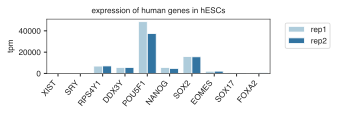

In [27]:
fig = plt.figure(figsize=(4, 1))

ax = sns.barplot(data=human_sub, x="gene_name", y="value", hue="variable", palette="Paired", 
                 order=human_genes_to_check)
#ax.set_yscale('symlog')
ax.set_xticklabels(human_genes_to_check, va="top", ha="right", rotation=50)
ax.set_ylabel("tpm")
ax.set_title("expression of human genes in hESCs")
ax.set_xlabel("")

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

In [39]:
mouse_genes_to_check = ["Xist", "Sry", "Eif2s3y", "Ddx3y", "Pou5f1", "Nanog", "Sox2", "Eomes", "Sox17", "Foxa2"]

In [40]:
mouse_sub = mESC_expr[mESC_expr["gene_name"].isin(mouse_genes_to_check)]
mouse_sub = pd.melt(mouse_sub[["gene_name", "rep1", "rep2", "rep3"]], id_vars="gene_name")
mouse_sub.head()

,gene_name,variable,value
0,Sox17,rep1,15.747757
1,Foxa2,rep1,11.248398
2,Sox2,rep1,26213.266644
3,Nanog,rep1,46427.762648
4,Eomes,rep1,557.920540


In [41]:
mouse_sub.gene_name.unique()

array(['Sox17', 'Foxa2', 'Sox2', 'Nanog', 'Eomes', 'Pou5f1', 'Xist',
       'Eif2s3y', 'Ddx3y', 'Sry'], dtype=object)

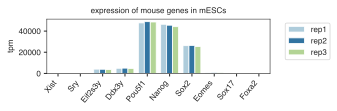

In [42]:
fig = plt.figure(figsize=(4, 1))

ax = sns.barplot(data=mouse_sub, x="gene_name", y="value", hue="variable", palette="Paired", 
                 order=mouse_genes_to_check)
#ax.set_yscale('symlog')
ax.set_xticklabels(mouse_genes_to_check, va="top", ha="right", rotation=50)
ax.set_ylabel("tpm")
ax.set_title("expression of mouse genes in mESCs")
ax.set_xlabel("")

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

## 3. look at expression of TFs in hESCs

In [44]:
uniq_human_TFs = human_map["gene_name"].unique()
print(len(uniq_human_TFs))

TFs_in_seq = [x for x in uniq_human_TFs if x in list(hESC_expr["gene_name"])]
print(len(TFs_in_seq))

TFs_missing = [x for x in uniq_human_TFs if x not in list(hESC_expr["gene_name"])]
print(len(TFs_missing))

529
508
21


In [45]:
TFs_missing

['ENSG00000250542',
 'ZNF187',
 'ZFP161',
 'MLL',
 'C11orf9',
 'PRKRIR',
 'AC002126.6',
 'MYCL1',
 'DUX1',
 'ENSG00000261932',
 'CHD2',
 'MTERF',
 'NFE4_HUMAN',
 'ZNF238',
 'ENSG00000269523',
 'ZNF271',
 'ZNF834',
 'ZNF542',
 'ZNF663',
 'ENSG00000178604',
 'ZNF883']

the above 21 TFs are missing from the RNA-seq so will not be included (I hand checked a few and couldn't find easy aliases, might look more later)

In [47]:
hESC_TFs = hESC_expr[hESC_expr["gene_name"].isin(uniq_human_TFs)]
print(len(hESC_TFs))
hESC_TFs.head()

511


,index,rep1,rep2,gene_id,biotype,gene_name
146,ENSG00000197921,81.852162,121.389585,ENSG00000197921.5_1,protein_coding,HES5
206,ENSG00000069812,25.801225,34.843307,ENSG00000069812.11_1,protein_coding,HES2
253,ENSG00000074800,92890.637744,88246.856627,ENSG00000074800.13_2,protein_coding,ENO1
504,ENSG00000009709,160.145534,320.333628,ENSG00000009709.11_1,protein_coding,PAX7
616,ENSG00000007968,549.833001,614.815770,ENSG00000007968.6_1,protein_coding,E2F2


In [ ]:
fig = plt.figure(figsize=(2, 2))



## 4. look at DE expression in mouse

In [43]:
orth_expr["gene_id_human"] = orth_expr["index"].str.split("__", expand=True)[0]
orth_expr["gene_id_mouse"] = orth_expr["index"].str.split("__", expand=True)[1]
orth_expr.head()

,index,hESC_rep1,hESC_rep2,mESC_rep1,mESC_rep2,mESC_rep3,gene_id_human,gene_id_mouse
0,ENSG00000187634__ENSMUSG00000096351,83.679350,79.231477,5.435120,5.175746,8.009315,ENSG00000187634,ENSMUSG00000096351
1,ENSG00000188976__ENSMUSG00000095567,6687.911089,5203.261186,14972.669086,14729.139239,15010.256691,ENSG00000188976,ENSMUSG00000095567
2,ENSG00000187961__ENSMUSG00000078485,896.564459,824.243874,714.174792,777.397116,744.065336,ENSG00000187961,ENSMUSG00000078485
3,ENSG00000187642__ENSMUSG00000078486,10.115086,4.730237,30.436673,22.773284,16.018629,ENSG00000187642,ENSMUSG00000078486
4,ENSG00000187608__ENSMUSG00000035692,502.076097,572.358731,6.522144,5.175746,4.004657,ENSG00000187608,ENSMUSG00000035692


In [13]:
orth_sub = orth[["Gene stable ID", "Mouse gene stable ID", "Gene name", "Mouse gene name"]].drop_duplicates()
orth_sub.columns = ["gene_id_human", "gene_id_mouse", "gene_name_human", "gene_name_mouse"]
orth_expr = orth_expr.merge(orth_sub, on=["gene_id_human", "gene_id_mouse"]).drop_duplicates()
orth_expr.head()

,index,hESC_rep1,hESC_rep2,mESC_rep1,mESC_rep2,mESC_rep3,gene_id_human,gene_id_mouse,gene_name_human,gene_name_mouse
0,ENSG00000187634__ENSMUSG00000096351,83.679350,79.231477,5.435120,5.175746,8.009315,ENSG00000187634,ENSMUSG00000096351,SAMD11,Samd11
1,ENSG00000188976__ENSMUSG00000095567,6687.911089,5203.261186,14972.669086,14729.139239,15010.256691,ENSG00000188976,ENSMUSG00000095567,NOC2L,Noc2l
2,ENSG00000187961__ENSMUSG00000078485,896.564459,824.243874,714.174792,777.397116,744.065336,ENSG00000187961,ENSMUSG00000078485,KLHL17,Plekhn1
3,ENSG00000187642__ENSMUSG00000078486,10.115086,4.730237,30.436673,22.773284,16.018629,ENSG00000187642,ENSMUSG00000078486,PERM1,Perm1
4,ENSG00000187608__ENSMUSG00000035692,502.076097,572.358731,6.522144,5.175746,4.004657,ENSG00000187608,ENSMUSG00000035692,ISG15,Isg15
